<center> <h3> <b> Investigating the Impact of Income-Related Factors on COVID-19 Death Rate Across Countries and the Moderating Role of the Prevention Policy Strength </b> </h3> </center>

<h3> Introduction </h3>

COVID-19 has a huge impact around the world, and countries with weaker economies are always more fragile to the spread of such outbreaks. At the micro level, personal income has a crucial impact on the resistance to the aggression brought about by the virus. A study by Cornell University found that income level—a key indicator of household access to healthcare resources, underlying health conditions, living and working environments, and preventive and coping capacity—is strongly linked to COVID-19 exposure (Rahman et al., 2023). However, in country-level studies, past researchers tend to overgeneralize incomes as GDP for examining COVID-19 outcomes. Therefore, this research aims to fill this gap by focusing on the specific contribution of income-related factors—such as national income level, income stability, employment vulnerability, and income inequality—to the pandemic's death rate. Moreover, this research also examines the effectiveness of government efforts to combat the virus in mediating this relationship. The goal of this paper is to provide a theoretical reference for governmental prevention policies in countries of all income statuses, helping them optimize their preventive measures and better protect themselves against the virus.
    
Many articles provide the basis for this study. A 2021 paper shows that the Gini coefficient is significantly associated with higher COVID-19 mortality across all age groups in 22 OECD countries (Sepulveda & Brooker, 2021). Similarly, another study provides evidence for the effect of **income inequality** on COVID-19 mortality rates (Tan et al., 2021). Additionally, a team of researchers studies **income level** on local outbreaks at the level of Korean provincial capitals and found its effect on virus transmission (Kim et al., 2021). In addition, a one-year longitudinal study spanning 44 countries provided the **modeling basis** for this study to use **panel data** to examine the COVID-19 pattern (Motallebi et al., 2021).
    
Just as appropriate support policies can help poor families out of their difficulties, appropriate **prevention and control policies** of nations can make up for their shortcomings in facing the virus at the economic level. This study seeks to inform feasible and effective public health policies.

<h3> Data Cleaning and Loading </h3>

Data used are all country-level data provided by the instructor or sourced from the World Bank, Oxford Database, OECD, and the International Labour Organization. The **cumulated case fatality rate (CFR)** of COVID-19 is the outcome variable representing the death rate of the virus, and variables of interest are the Gini index, unemployment, average wage, and informal employment rate which each represent an aspect of income. The **Gini Index** evaluates the income inequality. **Unemployment** and **informal employment** measure the income stability and the portion of fragile labor. The **monthly average wage** (measured in US dollars) evaluates the income level of a country. These variabels are considered as potential factors of COVID-19 death rate based on literature review.
    
Additionally, the **Stringent Index** is used to study the moderate effects on income factors, representing the overall policy tightness. It is a composite measure of Workplace Closures, Restrictions on Internal Movement, International Travel Controls, etc., which may place a burden on income. **Population** and **government health** investment are key control variables selected from literatures on COVID-19 studies.

The following shows the data loading and preprocessing process. The code has been optimized to the minimum.
CFR for each country is computed by the number of deaths divided by the number of confirmed cases from 2020 to 2022 and recorded weekly.

In [131]:
#Load the first dataset, including countries and their accumulated COVID-19 confirmed case
import pandas as pd
file_path = r"C:\Users\chenr\OneDrive\ECO225Project\Data\variables\time_series_covid19_confirmed_global.csv"
confirmed_data = pd.read_csv(file_path)
confirmed_data = confirmed_data.drop(columns=['Province/State', 'Long', 'Lat'], errors='ignore')
confirmed_data.columns = [col if col == "Country/Region" else pd.to_datetime(col, errors='coerce').date() for col in confirmed_data.columns]
date_columns = confirmed_data.columns[1:]  

start_date = pd.to_datetime("2020-02-01").date()
end_date = pd.to_datetime("2022-12-31").date()
weekly_dates = pd.date_range(start=start_date, end=end_date, freq='W-MON').date
available_dates = [min(date_columns, key=lambda x: abs(x - d)) for d in weekly_dates if min(date_columns, key=lambda x: abs(x - d)) in date_columns]
columns_to_keep = ["Country/Region"] + available_dates
confirmed_data_filtered = confirmed_data[columns_to_keep]
confirmed_data_filtered = confirmed_data_filtered.copy()
confirmed_data_filtered.rename(columns={'Country/Region': 'Country Name'}, inplace=True)

In [132]:
#load Death data
file_path = r"C:\Users\chenr\OneDrive\ECO225Project\Data\variables\time_series_covid19_deaths_global.csv"
Death_data = pd.read_csv(file_path)
Death_data = Death_data.drop(columns=['Province/State', 'Long', 'Lat'], errors='ignore')
Death_data.columns = [col if col == "Country/Region" else pd.to_datetime(col, errors='coerce').date() for col in Death_data.columns]
date_columns = Death_data.columns[1:]  
columns_to_keep = ["Country/Region"] + available_dates
Death_data_filtered = Death_data[columns_to_keep]
Death_data_filtered = Death_data_filtered.copy()
Death_data_filtered.rename(columns={'Country/Region': 'Country Name'}, inplace=True)

In [162]:
#calculate Case Fatality Rate (CFR)
Death_data_filtered = Death_data_filtered.copy()
confirmed_data_filtered = confirmed_data_filtered.copy()

Death_data_filtered.iloc[:, 1:] = Death_data_filtered.iloc[:, 1:].apply(pd.to_numeric, errors='coerce').astype(float)
confirmed_data_filtered.iloc[:, 1:] = confirmed_data_filtered.iloc[:, 1:].apply(pd.to_numeric, errors='coerce').astype(float)

# Calculate Case Fatality Rate (CFR) by dividing deaths by confirmed cases
cfr_df = Death_data_filtered.copy()
cfr_df.iloc[:, 1:] = (Death_data_filtered.iloc[:, 1:] / confirmed_data_filtered.iloc[:, 1:]) * 100

cfr_df.iloc[:, 1:] = cfr_df.iloc[:, 1:].fillna(0).replace([float('inf'), -float('inf')], 0)

The Stringent index is also recorded weekly for each country from 2020 to 2022.

In [134]:
#Load the 2nd dataset, including the stringent index
file_path = r"C:\Users\chenr\OneDrive\ECO225Project\Data\variables\OXFORD-CGRT.xlsx"
stringent = pd.read_excel(file_path)
stringent_id = stringent[stringent["Indicator ID"] == "OXFORD.CGRT.stringency_index"]
stringent = stringent_id.drop(columns=['Economy ISO3', 'Indicator ID', 'Indicator’， ‘Attribute 1', 'Attribute 2', 'Attribute 3', 'Partner'], errors='ignore')
stringent.columns = [col if col == "Economy Name" else pd.to_datetime(col, errors='coerce').date() for col in stringent.columns]

columns_to_keep = ["Economy Name"] + available_dates
stringent_filtered = stringent[columns_to_keep]
stringent_filtered = stringent_filtered.copy()
stringent_filtered.rename(columns={'Economy Name': 'Country Name'}, inplace=True)

Informal employment rate, unemployment rate, average wage, Gini Index, population, and government health investment are collected for 2020, 2021, and 2022. Due to the data's annual frequency and gaps in certain years, I first filtered out countries with no updated data from 2020 to 2022. Then, I filled the NAs with the most recent update to ensure consistency in the analysis.

In [135]:
#Load the 3rd dataset, including countries and their informal employment rate
pd.set_option('future.no_silent_downcasting', True)
file_path = r"C:\Users\chenr\OneDrive\ECO225Project\Data\variables\SDG_0831_SEX_ECO_RT_A-20250201T1718.csv"
Inefficient_Employment = pd.read_csv(file_path)
columns_to_keep = ['ref_area.label', 'time', 'obs_value'] 
Inefficient_Employment = Inefficient_Employment[columns_to_keep]
pivot_Inefficient_Employment = Inefficient_Employment.pivot(index='ref_area.label', columns='time', values='obs_value')
pivot_Inefficient_Employment.reset_index(inplace=True)
pivot_Inefficient_Employment = pivot_Inefficient_Employment.drop(columns=[2019])
pivot_Inefficient_Employment.columns = pivot_Inefficient_Employment.columns.astype(str)
pivot_Inefficient_Employment = pivot_Inefficient_Employment.dropna(how='all', subset=['2020', '2021', '2022'])
pivot_Inefficient_Employment = pivot_Inefficient_Employment.bfill(axis=1).ffill(axis=1)
pivot_Inefficient_Employment = pivot_Inefficient_Employment.copy()
pivot_Inefficient_Employment.rename(columns={'ref_area.label': 'Country Name'}, inplace=True)

In [136]:
#Load the 4th dataset, including the unemployment rate of each country 
file_path = r"C:\Users\chenr\OneDrive\ECO225Project\Data\variables\API_SL.UEM.TOTL.NE.ZS_DS2_en_csv_v2_3129.csv"
unemployment = pd.read_csv(file_path, skiprows=4)
unemployment_keep = ['Country Name', '2020', '2021', '2022'] 
unemployment_filtered = unemployment[unemployment_keep]
unemployment_filtered_cleaned = unemployment_filtered[unemployment_filtered.iloc[:, 1:].notna().any(axis=1)]
unemployment_filtered_cleaned_filled = unemployment_filtered_cleaned.bfill(axis=1).ffill(axis=1)

In [137]:
#Load the 5th dataset, including the average wage of each country
file_path = r"C:\Users\chenr\OneDrive\ECO225Project\Data\variables\EAR_4MTH_SEX_CUR_NB_A-20250202T1501.csv"
avg_wage = pd.read_csv(file_path)
avg_wage_cur = avg_wage[avg_wage["classif1.label"] == "Currency: U.S. dollars"]
avg_wage_keep = ['ref_area.label', 'time', 'obs_value'] 
avg_wage_filtered = avg_wage_cur[avg_wage_keep]
pivot_avg_wage_filtered = avg_wage_filtered.pivot(index='ref_area.label', columns='time', values='obs_value')
pivot_avg_wage_filtered.reset_index(inplace=True)
pivot_avg_wage_filtered = pivot_avg_wage_filtered.drop(columns=[2019])
pivot_avg_wage_filtered.columns = pivot_avg_wage_filtered.columns.astype(str)
pivot_avg_wage_filtered = pivot_avg_wage_filtered.dropna(how='all', subset=['2020', '2021', '2022'])
pivot_avg_wage_filtered = pivot_avg_wage_filtered.bfill(axis=1).ffill(axis=1)
pivot_avg_wage_filtered.rename(columns={'ref_area.label': 'Country Name'}, inplace=True)

In [138]:
#Load the 6th dataset, including the gini coefficient of each country
file_path = r"C:\Users\chenr\OneDrive\ECO225Project\Data\variables\API_SI.POV.GINI_DS2_en_csv_v2_53.csv"
gini = pd.read_csv(file_path, skiprows=4)
gini_keep = ['Country Name', '2020', '2021', '2022'] 
gini_filtered = gini[gini_keep]
gini_filtered_cleaned = gini_filtered[gini_filtered.iloc[:, 1:].notna().any(axis=1)]
gini_filtered_cleaned_filled = gini_filtered_cleaned.bfill(axis=1).ffill(axis=1)

In [139]:
#Load the 7th dataset, including the population of each country
file_path = r"C:\Users\chenr\OneDrive\ECO225Project\Data\variables\API_SP.POP.TOTL_DS2_en_csv_v2_87.csv"
population = pd.read_csv(file_path, skiprows=4)
population_keep = ['Country Name', '2020', '2021', '2022'] 
population_filtered = population[population_keep]
population_filtered_cleaned = population_filtered[population_filtered.iloc[:, 1:].notna().any(axis=1)]
population_filtered_cleaned_filled = population_filtered_cleaned.bfill(axis=1).ffill(axis=1)

In [140]:
#Load the 8th dataset, including government health spending of each country
file_path = r"C:\Users\chenr\OneDrive\ECO225Project\Data\variables\gvmt_heath_spending.xlsx"
gvmt_spending = pd.read_excel(file_path)
gvmt_spending.columns = gvmt_spending.columns.astype(str)

<h3> Summary Statistics Tables </h3>

In [141]:
#merge data base on date and country for informal employment rate, unemployment rate, average wage, GINI Index, population, and government health investment
Inefficient_melted = pd.melt(pivot_Inefficient_Employment, id_vars=['Country Name'], var_name='year', value_name='Inefficient Employment')
Unemployment_melted = pd.melt(unemployment_filtered_cleaned_filled, id_vars=['Country Name'], var_name='year', value_name='Unemployment Rate')
Avg_wage_melted = pd.melt(pivot_avg_wage_filtered, id_vars=['Country Name'], var_name='year', value_name='Average Monthly wage')
Gini_melted = pd.melt(gini_filtered_cleaned_filled, id_vars=['Country Name'], var_name='year', value_name='Gini Index')
Population_melted = pd.melt(population_filtered_cleaned_filled, id_vars=['Country Name'], var_name='year', value_name='Population')
Health_spend_melted = pd.melt(gvmt_spending, id_vars=['Country Name'], var_name='year', value_name='Government Health Spending')

tables = [Avg_wage_melted, Inefficient_melted, Unemployment_melted, Gini_melted, Population_melted, Health_spend_melted]
from functools import reduce
year_table = reduce(lambda left, right: left.merge(right, on=['Country Name', 'year'], how='inner'), tables)

unique_countries = year_table['Country Name'].unique()

34 countries are covered in the study.

In [142]:
#merge data base on date and country for CRF and Stringent index
cfr_df = cfr_df[confirmed_data_filtered['Country Name'].isin(unique_countries)]
CRF_melted = pd.melt(cfr_df, id_vars=['Country Name'], var_name='date', value_name='CFR')
stringent_filtered = stringent_filtered[stringent_filtered['Country Name'].isin(unique_countries)]
Stringent_melted = pd.melt(stringent_filtered, id_vars=['Country Name'], var_name='date', value_name='Stringent Index')

date_table = CRF_melted.merge(Stringent_melted, on=['Country Name', 'date'], how='inner')

unique_countries1 = date_table['Country Name'].unique()
print(unique_countries1)

['Argentina' 'Austria' 'Belgium' 'Brazil' 'Bulgaria' 'Chile' 'Colombia'
 'Costa Rica' 'Croatia' 'Cyprus' 'Czechia' 'Estonia' 'Finland' 'France'
 'Germany' 'Greece' 'Hungary' 'India' 'Indonesia' 'Ireland' 'Italy'
 'Latvia' 'Lithuania' 'Luxembourg' 'Malta' 'Mexico' 'Netherlands' 'Peru'
 'Poland' 'Portugal' 'Slovenia' 'Spain' 'Sweden' 'Switzerland']


In [143]:
#merge all data and create a table
date_table['year'] = pd.to_datetime(date_table['date']).dt.year
date_table['year'] = date_table['year'].astype(int)
year_table['year'] = year_table['year'].astype(int)
merged_data = date_table.merge(year_table, on=['Country Name', 'year'], how='inner')
merged_data.drop(columns=['year'], inplace=True)

 The table below provides a brief overview of the data. The dependent variable, CFR, varies across both countries and time, indicating a panel data structure. There are 7447 observations and 8 variables.

<h4 style='text-align: center;'>Table 1: Overview of All Variables</h4>

In [144]:
ellipsis_row = pd.DataFrame([["..."] * merged_data.shape[1]], columns=merged_data.columns)
subset_data = pd.concat([merged_data.head(7), ellipsis_row, merged_data.tail(6)], ignore_index=True)
styled_table = subset_data.style.set_properties(**{
    'border': '1px solid black',
    'padding': '5px',
    'text-align': 'center'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#f2f2f2'), ('font-weight', 'bold')]}
])

display(styled_table)

,Country Name,date,CFR,Stringent Index,Average Monthly wage,Inefficient Employment,Unemployment Rate,Gini Index,Population,Government Health Spending
0,Argentina,2020-02-03,0.000000,11.110000,514.353000,46.981000,11.461000,42.700000,45191965.000000,1443.829000
1,Austria,2020-02-03,0.000000,0.000000,4753.406000,1.978000,5.201000,29.800000,8916864.000000,4504.759000
2,Belgium,2020-02-03,0.000000,11.110000,5760.266000,1.262000,5.545000,26.000000,11538604.000000,4292.961000
3,Brazil,2020-02-03,0.000000,5.560000,477.027000,36.730000,13.697000,48.900000,208660842.000000,705.140000
4,Bulgaria,2020-02-03,0.000000,2.780000,855.426000,2.726000,5.125000,40.500000,6934015.000000,1339.922000
5,Chile,2020-02-03,0.000000,0.000000,928.035000,25.830000,10.934000,47.000000,19370624.000000,1571.871000
6,Colombia,2020-02-03,0.000000,8.330000,337.566000,63.242000,15.983000,53.500000,50629997.000000,1001.512000
7,...,...,...,...,...,...,...,...,...,...
8,Poland,2022-12-26,1.861165,9.260000,1347.444000,9.778000,2.811000,28.500000,36821749.000000,2226.635000
9,Portugal,2022-12-26,0.462977,11.110000,1092.995000,4.585000,6.011000,34.600000,10434332.000000,2640.476000


The following table shows the distribution of each variable, including the 25th quantile, mean, 75th quantile, and standard deviation. The average CFR is 2.05%, meaning about 2.05% of confirmed COVID-19 cases resulted in death. Additionally, its variance is about 2.644^2 = 6.99, which is much bigger than its mean, indicating overdispersion. This suggests that I should take overdispersion into consideration in further analysis especially when selecting the regression model. 

<h4 style='text-align: center;'>Table 2: Statistical Properties of All Variables</h4>

In [145]:
columns_of_interest = ['CFR', 'Stringent Index', 'Average Monthly wage', 'Inefficient Employment', 
                       'Unemployment Rate', 'Gini Index', 'Population', 'Government Health Spending']
summary_stats = merged_data[columns_of_interest].agg(
    ['mean', 'std', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)]
).transpose()
summary_stats.columns = ['Mean', 'Std. Dev.', '25th Quantile', '75th Quantile']
summary_stats_df = pd.DataFrame(summary_stats)
summary_stats_df = summary_stats_df.transpose()

display(summary_stats_df)

,CFR,Stringent Index,Average Monthly wage,Inefficient Employment,Unemployment Rate,Gini Index,Population,Government Health Spending
Mean,2.047107,44.347840,3051.239644,13.097319,6.891193,33.059184,6.989359e+07,3556.500304
Std. Dev.,2.644011,24.026051,1943.511331,22.543073,3.012553,6.535101,2.008320e+08,1856.731606
25th Quantile,0.557335,19.380000,1189.738000,2.386000,4.268000,29.500000,8.638167e+06,1817.666000
75th Quantile,2.411107,63.890000,4561.813000,4.585000,8.010000,34.600000,6.784281e+07,5241.151000


The following table shows an overview of the distribution of each variable of each country, including the 25th quantile, mean, 75th quantile, and standard deviation. Only data of 3 countries are displayed out of 34 countries. The distribution (mean and spread) for each variable shows great discrepancy among countries, indicating that we must conduct the study by country subgroups to ensure that the coefficient outputs of regression are plausible in future analysis.

<h4 style='text-align: center;'>Table 3: Statistical Properties of All Variables Grouped by Country</h4>

In [146]:
country_summary_stats = merged_data.groupby('Country Name')[columns_of_interest].agg(
    [lambda x: x.quantile(0.25), 'mean', lambda x: x.quantile(0.75), 'std']
)
country_summary_stats = country_summary_stats.stack(level=1, future_stack=True)

display(country_summary_stats.head(12))

CFR  Stringent Index Average Monthly wage  \
Country Name                                                              
Argentina    <lambda_0>  1.408115        19.035000              514.353   
             mean        2.073458        53.885263           566.361553   
             <lambda_1>  2.431858        79.400000              635.912   
             std         0.988505        31.167209             51.82144   
Austria      <lambda_0>  0.464774        35.190000             4482.209   
             mean        1.656031        50.566579          4764.565816   
             <lambda_1>  2.118086        64.952500             5057.224   
             std         1.243686        18.430955           238.725029   
Belgium      <lambda_0>  0.765155        16.895000             5705.315   
             mean        3.789238        41.170921          5869.107474   
             <lambda_1>  2.964950        60.190000             6133.369   
             std         4.838193        21.428740           192.492557   

                        Inefficient Employment Unemployment Rate Gini Index  \
Country Name                                                                  
Argentina    <lambda_0>                 46.981             6.805       40.7   
             mean                    49.162263          8.935921  41.913158   
             <lambda_1>                 51.196            11.461       42.7   
             std                      1.713749          1.898501   0.886147   
Austria      <lambda_0>                  1.381             4.992       29.8   
             mean                     1.626658          5.559868  30.415789   
             <lambda_1>                  1.978             6.459       30.7   
             std                      0.249304          0.656043    0.41973   
Belgium      <lambda_0>                  1.262             5.545       26.0   
             mean                     1.331447          5.794053  26.410526   
             <lambda_1>                  1.465             6.248       26.6   
             std                      0.096625          0.328585    0.27982   

                              Population  Government Health Spending  
Country Name                                                          
Argentina    <lambda_0>       45191965.0                 1443.829000  
             mean        45306999.605263                 1443.829000  
             <lambda_1>       45407904.0                 1443.829000  
             std            87877.125985                    0.000000  
Austria      <lambda_0>        8916864.0                 4504.759000  
             mean         8972941.894737                 5153.162395  
             <lambda_1>        9041851.0                 5663.700000  
             std            52307.831074                  475.469844  
Belgium      <lambda_0>       11538604.0                 4292.961000  
             mean        11603329.289474                 4684.912368  
             <lambda_1>       11680210.0                 5057.595000  
             std            58892.047388                  310.975829

<h3> Visualizations </h3>

The line graph below shows how CFR of each country evolves over time. This line graph is a visual representation of Table 3, which shows that despite the similarity of trends, CFR varies greatly between countries. This again suggests that in subsequent analyses we should first test for individual effects in each country rather than just combine all the data and analyze the world CFR as a whole. This graph also shows that all 34 countries experienced a surge and a sharp decline in CFR in 2020 and a slow decline in 2021, all leveling off at different levels of CFRs in 2022. The few sharp spikes at the start may be due to incomplete quarantine and testing measures at the beginning of the outbreak, resulting in confirmed cases lagging behind the number of deaths, which are more amenable to observation. Moreover, the outbreak started at different times across countries. The changes in CFR over time again suggest that I should consider the time series effect.

Because the CFR for the first year is highly unstable, and there are a lot of biased observations (spikes) caused by statistical issues, I might consider applying only the more stable and responsive 2021 and 2022 data in subsequent studies. However, this decision will depend on the actual situation.

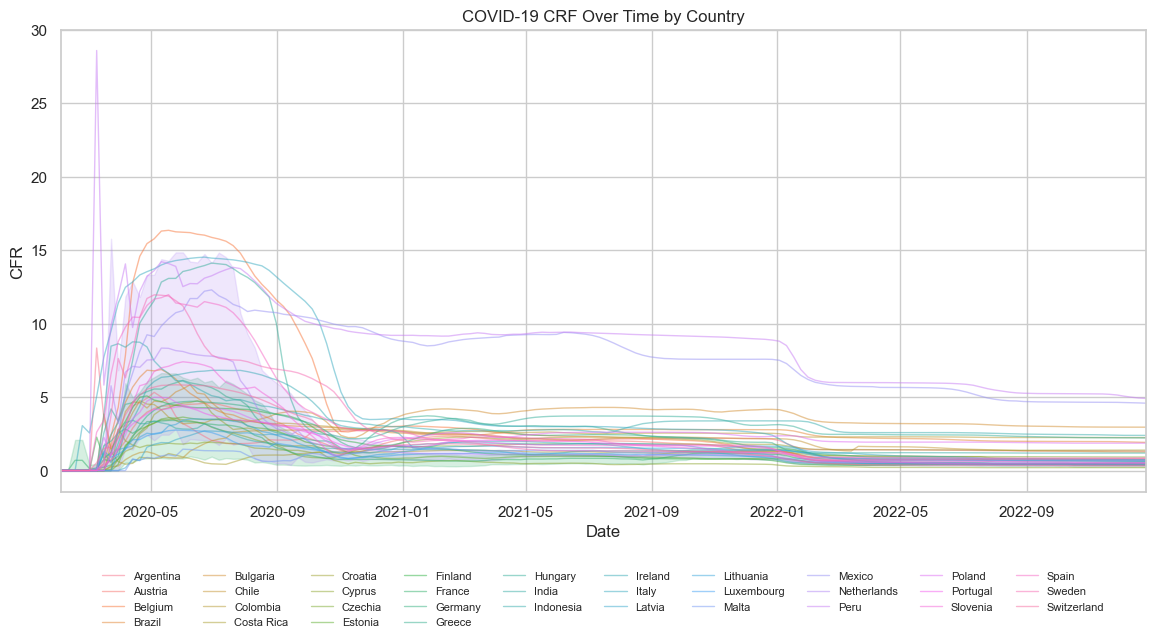

In [147]:
#the change of Confirmed by Date for each country
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(14, 6))

sns.lineplot(data=merged_data, x="date", y="CFR", hue="Country Name", alpha=0.5, linewidth=1)

plt.xlim(merged_data["date"].min(), pd.to_datetime("2022-12-26"))
plt.title("COVID-19 CRF Over Time by Country")
plt.xlabel("Date")
plt.ylabel("CFR")
plt.legend(
    loc="upper center",         
    bbox_to_anchor=(0.5, -0.15),  
    ncol=10,                    
    fontsize=8,                  
    frameon=False                
) 

The following graph is a break down of the previews graph. I selected 3 countries to better visualize their differences in CFR between countries and across time.

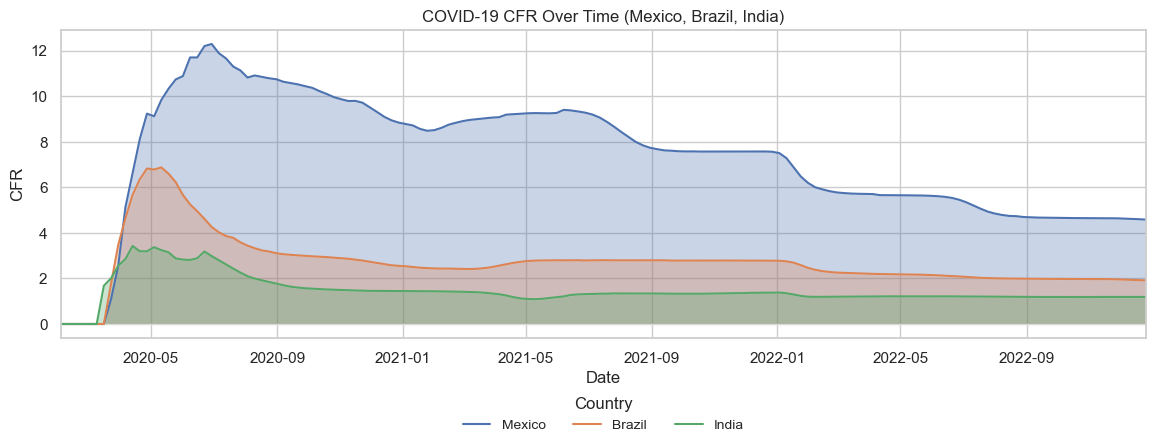

In [170]:
selected_countries = ["Mexico", "Brazil", "India"]
filtered_data = merged_data[merged_data["Country Name"].isin(selected_countries)]

sns.set(style="whitegrid")
plt.figure(figsize=(14, 4))

for country in selected_countries:
    country_data = filtered_data[filtered_data["Country Name"] == country]
    sns.lineplot(
        data=country_data, 
        x="date", 
        y="CFR", 
        label=country, 
        linewidth=1.5
    )
    plt.fill_between(
        country_data["date"], 
        country_data["CFR"], 
        alpha=0.3
    )

plt.xlim(filtered_data["date"].min(), pd.to_datetime("2022-12-26"))
plt.title("COVID-19 CFR Over Time (Mexico, Brazil, India)")
plt.xlabel("Date")
plt.ylabel("CFR")
plt.legend(
    title="Country",
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=3,
    fontsize=10,
    frameon=False
)

plt.show()

The following histograms show the distribution of CRF for each half-year. In general, the CFR follows a right-skew distribution. Based on the statistical nature (count data) and related literature, such a distribution suggests that I should prioritize the negative binomial distribution or similar GLMs in further research. Additionally, the distributions for the same year have similar mean and spread, and there is a general downward trend over time in both mean and spread. This again emphasizes the importance of including the time effect in analysis.

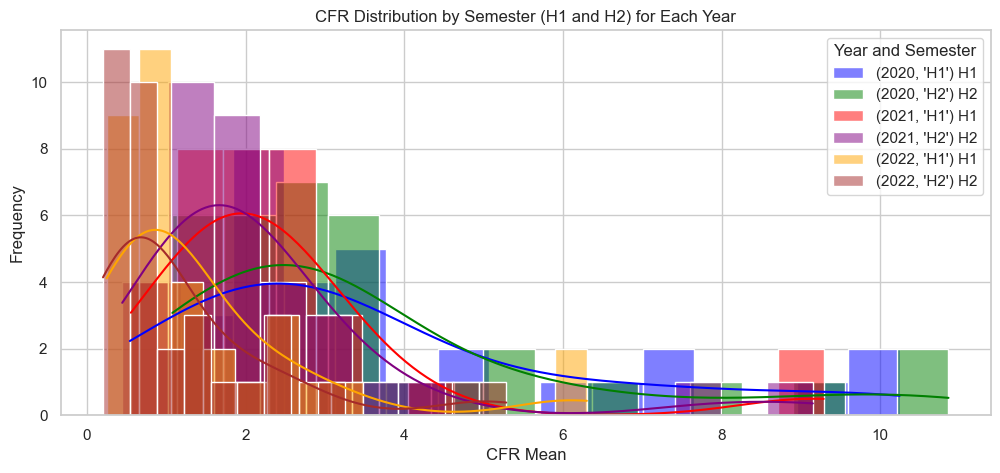

In [175]:
merged_data["date"] = pd.to_datetime(merged_data["date"], errors='coerce')
merged_data['year'] = merged_data['date'].dt.year
merged_data['month'] = merged_data['date'].dt.month
merged_data['semester'] = merged_data['month'].apply(lambda x: 'H1' if x <= 6 else 'H2')

semester_means = merged_data.groupby(['year', 'semester', 'Country Name'])['CFR'].mean().reset_index()

plt.figure(figsize=(12, 5))
sns.set(style="whitegrid")
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']

for i, (year, semester) in enumerate(semester_means.groupby(['year', 'semester'])):
    semester_data = semester['CFR']
    label = f"{year} {semester.iloc[0]['semester']}"  
    sns.histplot(semester_data, kde=True, bins=15, color=colors[i % len(colors)], label=label, alpha=0.5)

plt.title("CFR Distribution by Semester (H1 and H2) for Each Year")
plt.xlabel("CFR Mean")
plt.ylabel("Frequency")
plt.legend(title="Year and Semester")

plt.show()

The following box plots show the distribution of the Stringent Index for each half-year. The overall policy tightness is increasing from the first half of 2020 to the first half of 2021 and then continues to decline over time. The spread is the largest in the 2nd half of 2020, meaning that there is a great deal of variation in prevention policies across countries at the beginning of the outbreak.

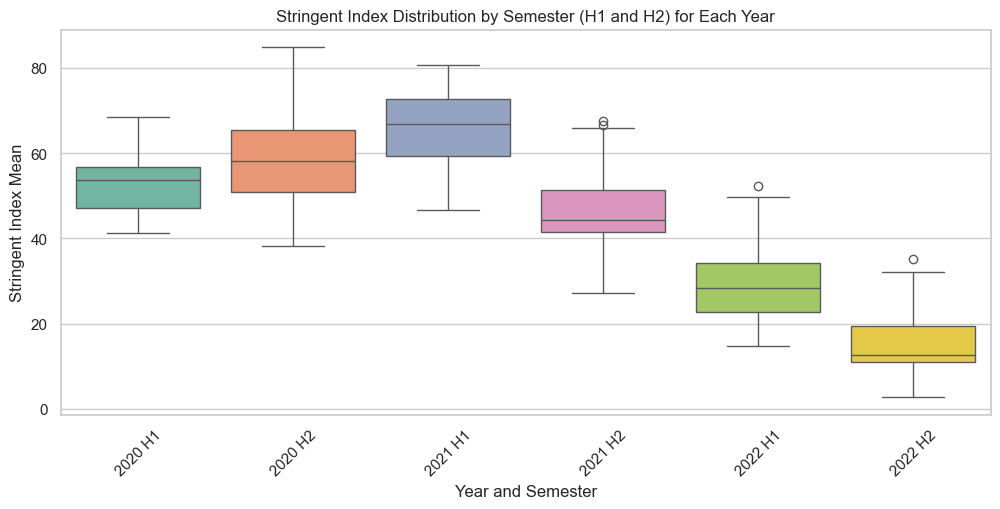

In [174]:
semester_means = merged_data.groupby(['year', 'semester', 'Country Name'])['Stringent Index'].mean().reset_index()
semester_means['year_semester'] = semester_means['year'].astype(str) + " " + semester_means['semester']

plt.figure(figsize=(12, 5))
sns.set(style="whitegrid")

sns.boxplot(x='year_semester', y='Stringent Index', hue='year_semester', data=semester_means, palette="Set2", legend=False)

plt.title("Stringent Index Distribution by Semester (H1 and H2) for Each Year")
plt.xlabel("Year and Semester")
plt.ylabel("Stringent Index Mean")
plt.xticks(rotation=45)  
plt.show()

The following graph shows the relationship between the stringent index and CFR. Although not following a strict linear relationship, there are higher stringent indexes for higher CRFs, suggesting that governments tend to actively react to high CFRs by tightening prevention policies to reduce mortality. Based on literatures, the stringent index is a composite measure of Workplace Closures, Restrictions on Internal Movement, International Travel Controls, and so on, which may place a burden on income. It is therefore reasonable to examine whether government interventions have intensified epidemic pressures in terms of the interest of research——income. 

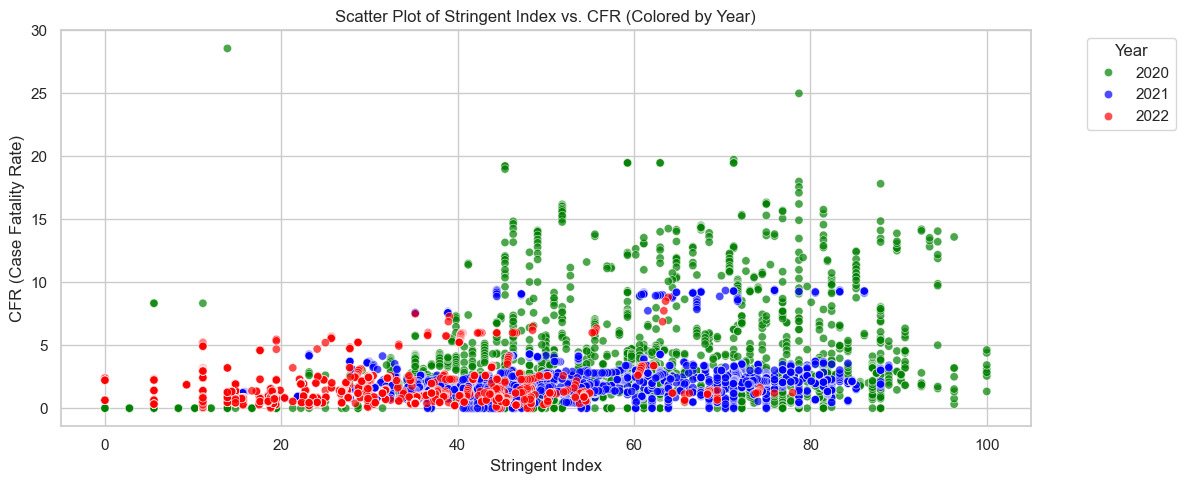

In [165]:
plt.figure(figsize=(12, 5))
sns.set(style="whitegrid")

color_map = {2020: 'green', 2021: 'blue', 2022: 'red'}
sns.scatterplot(x='Stringent Index', y='CFR', hue='year', data=merged_data, palette=color_map, alpha=0.7)

plt.title("Scatter Plot of Stringent Index vs. CFR (Colored by Year)")
plt.xlabel("Stringent Index")
plt.ylabel("CFR (Case Fatality Rate)")
plt.legend(title="Year", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

The following bar plots show the rank of countries in the Gini coefficient. The ranks in 2022 and 2021 are compared to the past year. Since the Gini index is collected annually, I only use the last appeared date of each year in the dataset. Ascending ranks are colored in yellow, and descending ranks are colored in green. The graph suggests that there are some changes in rank between 2021 and 2020. These are small ranking fluctuations. The ranking does not change in 2022. However, it does not mean the values of the Gini index remain the same. In general, although there are large differences in income inequality between countries, it has not changed significantly over time within countries.

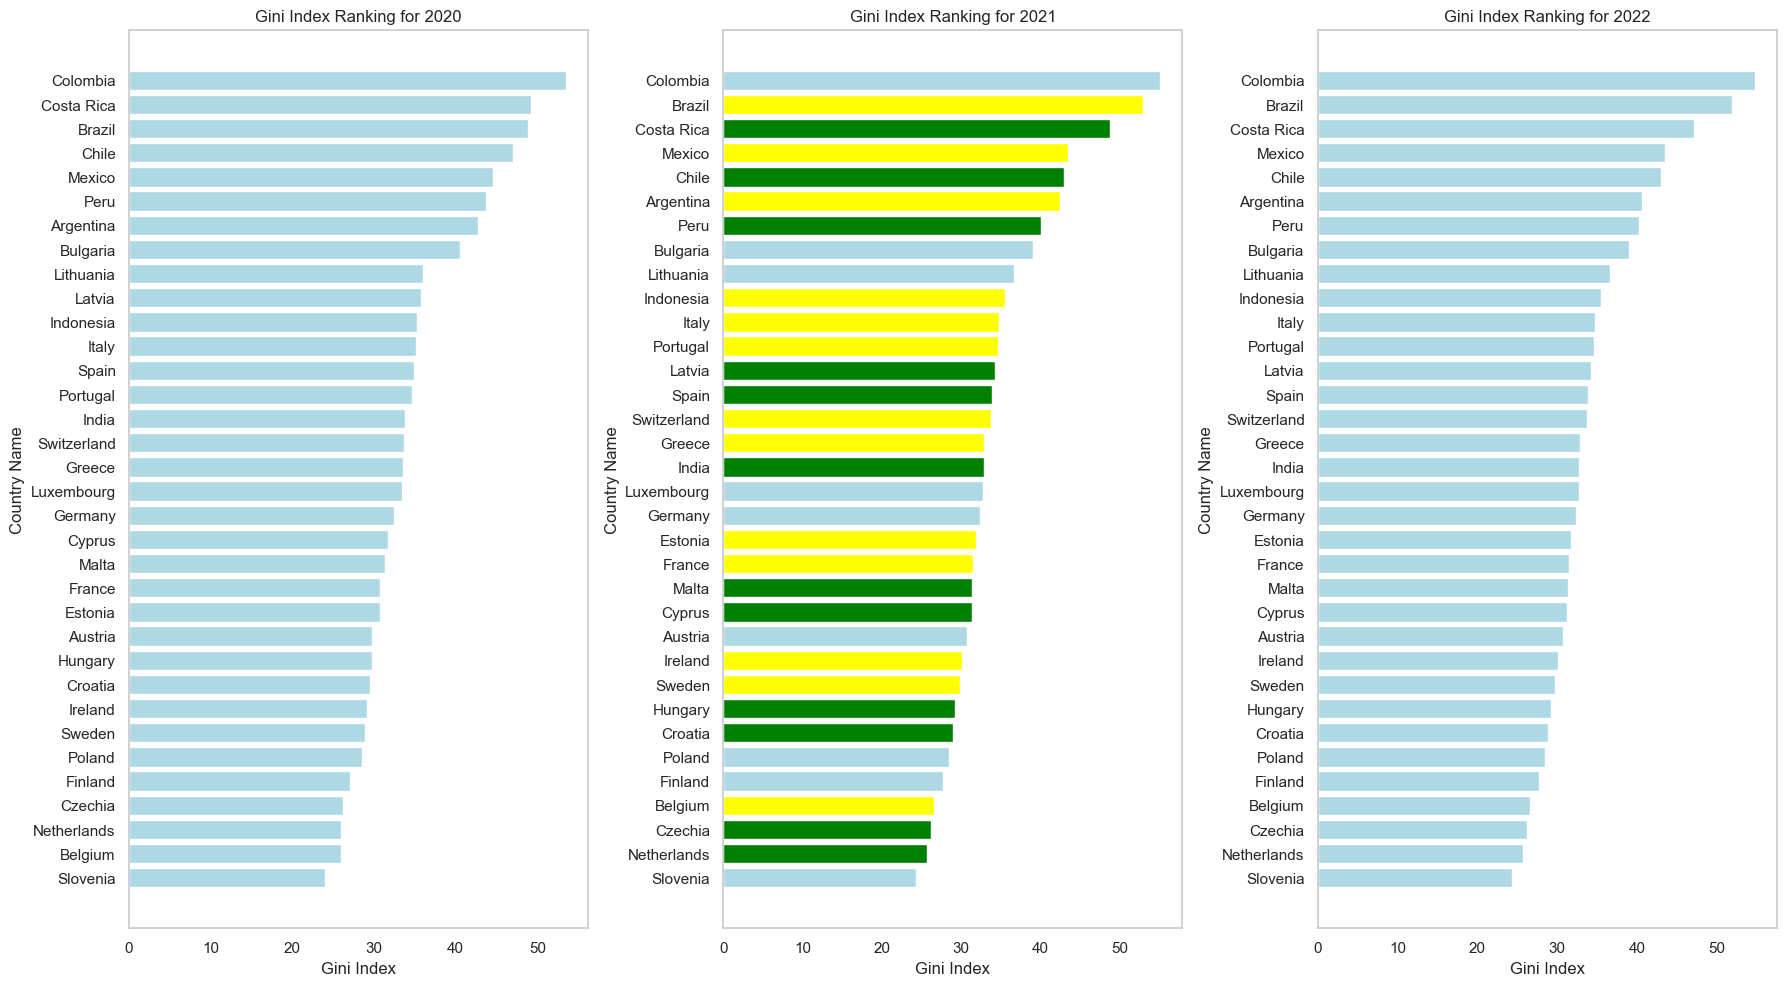

In [152]:
last_data_per_year = merged_data.groupby(['Country Name', 'year']).last().reset_index()
last_data_per_year['Rank'] = last_data_per_year.groupby('year')['Gini Index'].rank(method='min', ascending=False)

gini_wide = last_data_per_year.pivot(index='Country Name', columns='year', values='Rank')
gini_wide['Rank Change 2'] = gini_wide[2022] - gini_wide[2021]
gini_wide['Rank Change 1'] = gini_wide[2021] - gini_wide[2020]

plt.figure(figsize=(18, 10))
sns.set(style="whitegrid")

years = last_data_per_year['year'].unique()

for i, year in enumerate(years):
    year_data = last_data_per_year[last_data_per_year['year'] == year]
    year_data = year_data.sort_values(by='Gini Index', ascending=True)
    if year == 2022:
        year_data['Color'] = year_data['Country Name'].apply(
            lambda country: 'green' if gini_wide.loc[country, 'Rank Change 2'] > 0 else 
            ('yellow' if gini_wide.loc[country, 'Rank Change 2'] < 0 else 'lightblue')
        )
    elif year == 2021:
        year_data['Color'] = year_data['Country Name'].apply(
            lambda country: 'green' if gini_wide.loc[country, 'Rank Change 1'] > 0 else 
            ('yellow' if gini_wide.loc[country, 'Rank Change 1'] < 0 else 'lightblue')
        )
    else:
        year_data['Color'] = 'lightblue'  

    ax = plt.subplot(1, len(years), i + 1)
    for idx, row in year_data.iterrows():
        ax.barh(row['Country Name'], row['Gini Index'], color=row['Color'])

    ax.set_title(f"Gini Index Ranking for {year}")
    ax.set_xlabel("Gini Index")
    ax.set_ylabel("Country Name")
    ax.grid(False)  

plt.tight_layout(pad=1)
plt.show()

Only data in Decembers are selected to avoid the time effect. The average and variance of CFR are higher for higher Gini index, while the relationship for those with Gini index below 35 is not so obvious.

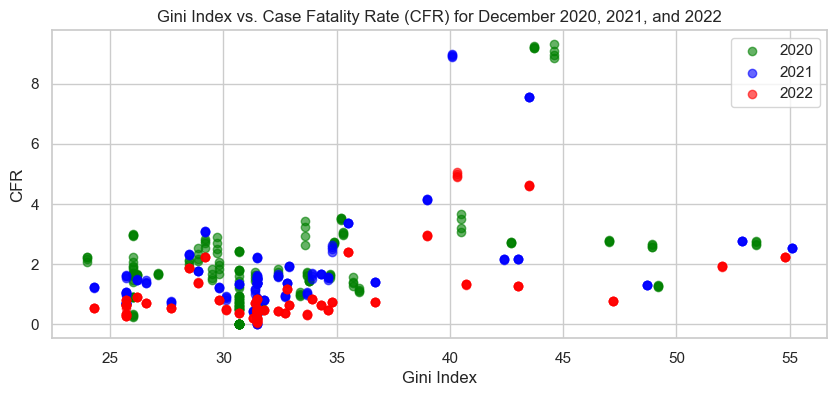

In [166]:
december_data = merged_data[merged_data['date'].dt.month == 12]

plt.figure(figsize=(10, 4))

plt.scatter(december_data[december_data['date'].dt.year == 2020]['Gini Index'],
            december_data[december_data['date'].dt.year == 2020]['CFR'],
            alpha=0.6, label='2020', color='green')
plt.scatter(december_data[december_data['date'].dt.year == 2021]['Gini Index'],
            december_data[december_data['date'].dt.year == 2021]['CFR'],
            alpha=0.6, label='2021', color='blue')
plt.scatter(december_data[december_data['date'].dt.year == 2022]['Gini Index'],
            december_data[december_data['date'].dt.year == 2022]['CFR'],
            alpha=0.6, label='2022', color='red')

plt.title('Gini Index vs. Case Fatality Rate (CFR) for December 2020, 2021, and 2022')
plt.xlabel('Gini Index')
plt.ylabel('CFR')
plt.legend()

plt.show()

The graph below show the changing rank on unemployment rate. The changes are small fluctuations, but the disparity between countries is large.

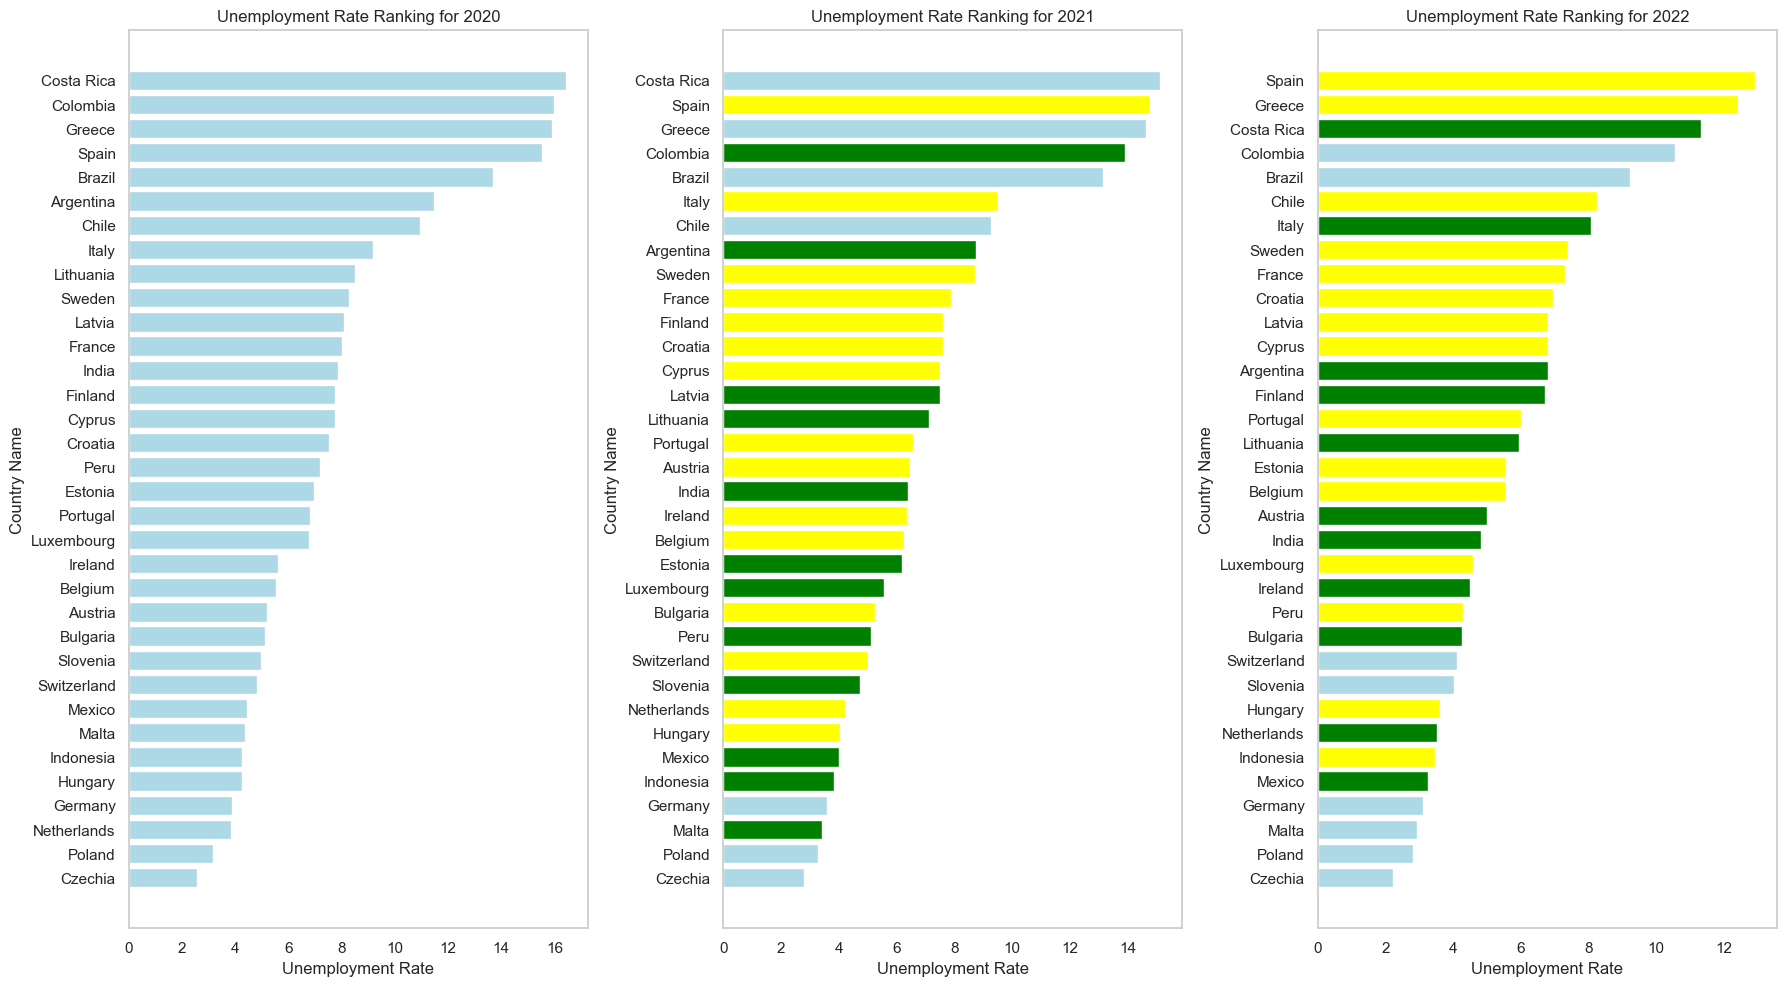

In [154]:
last_data_per_year['Rank'] = last_data_per_year.groupby('year')['Unemployment Rate'].rank(method='min', ascending=False)
unemployment_wide = last_data_per_year.pivot(index='Country Name', columns='year', values='Rank')

unemployment_wide['Rank Change 2'] = unemployment_wide[2022] - unemployment_wide[2021]
unemployment_wide['Rank Change 1'] = unemployment_wide[2021] - unemployment_wide[2020]

plt.figure(figsize=(18, 10))
sns.set(style="whitegrid")

for i, year in enumerate(years):
    year_data = last_data_per_year[last_data_per_year['year'] == year]
    year_data = year_data.sort_values(by='Unemployment Rate', ascending=True)

    if year == 2022:
        year_data['Color'] = year_data['Country Name'].apply(
            lambda country: 'green' if unemployment_wide.loc[country, 'Rank Change 2'] > 0 else 
            ('yellow' if unemployment_wide.loc[country, 'Rank Change 2'] < 0 else 'lightblue')
        )
    elif year == 2021:
        year_data['Color'] = year_data['Country Name'].apply(
            lambda country: 'green' if unemployment_wide.loc[country, 'Rank Change 1'] > 0 else 
            ('yellow' if unemployment_wide.loc[country, 'Rank Change 1'] < 0 else 'lightblue')
        )
    else:
        year_data['Color'] = 'lightblue' 

    ax = plt.subplot(1, len(years), i + 1)
    for idx, row in year_data.iterrows():
        ax.barh(row['Country Name'], row['Unemployment Rate'], color=row['Color'])

    ax.set_title(f"Unemployment Rate Ranking for {year}")
    ax.set_xlabel("Unemployment Rate")
    ax.set_ylabel("Country Name")
    ax.grid(False) 

plt.tight_layout(pad=1)
plt.show()

The scatter plot shows that there is no obvious relationship between unemployment rate and CFR. The unemployment rate is considered to be removed if the model fitting test suggests the same thing.

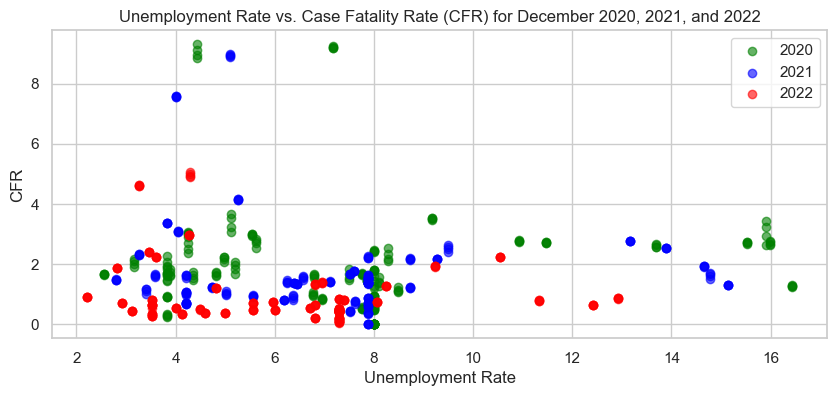

In [167]:
plt.figure(figsize=(10, 4))

plt.scatter(december_data[december_data['date'].dt.year == 2020]['Unemployment Rate'],
            december_data[december_data['date'].dt.year == 2020]['CFR'],
            alpha=0.6, label='2020', color='green')
plt.scatter(december_data[december_data['date'].dt.year == 2021]['Unemployment Rate'],
            december_data[december_data['date'].dt.year == 2021]['CFR'],
            alpha=0.6, label='2021', color='blue')
plt.scatter(december_data[december_data['date'].dt.year == 2022]['Unemployment Rate'],
            december_data[december_data['date'].dt.year == 2022]['CFR'],
            alpha=0.6, label='2022', color='red')

plt.title('Unemployment Rate vs. Case Fatality Rate (CFR) for December 2020, 2021, and 2022')
plt.xlabel('Unemployment Rate')
plt.ylabel('CFR')
plt.legend()

plt.show()

The change in rank of average wage is more significant in 2021 compare to 2022. Again, there is great disparity between countries.

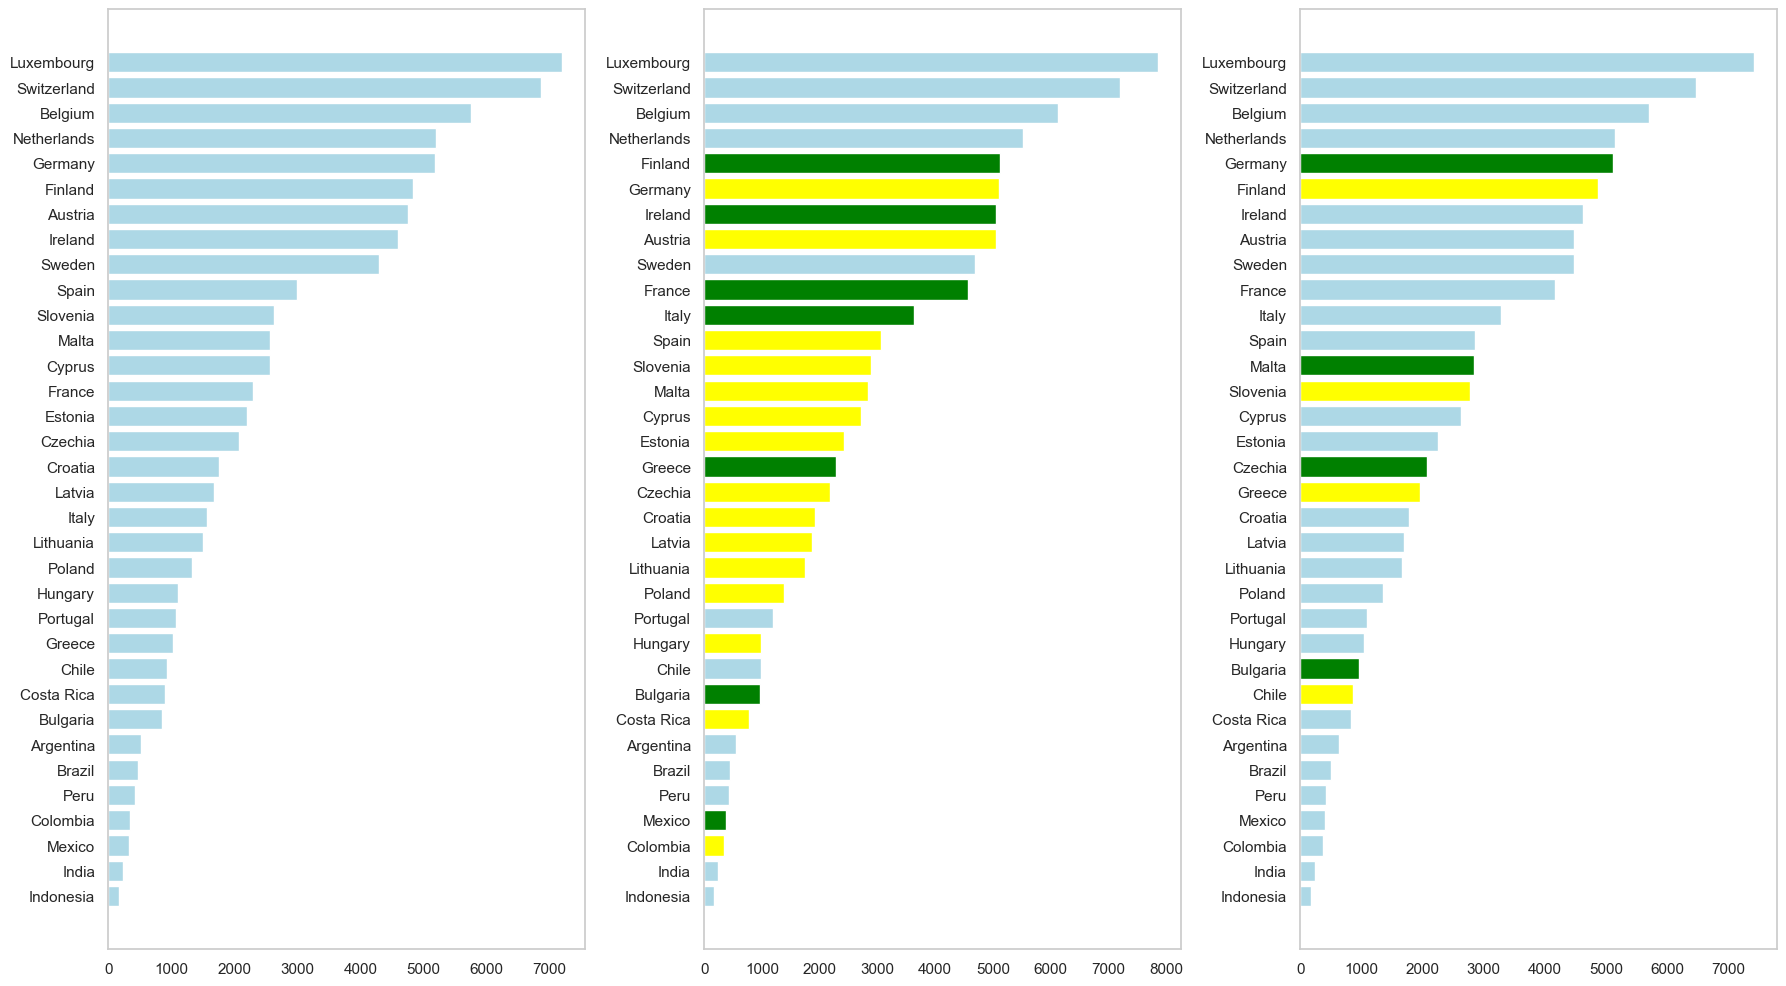

In [156]:
last_data_per_year['Rank'] = last_data_per_year.groupby('year')['Average Monthly wage'].rank(method='min', ascending=False)
wage_wide = last_data_per_year.pivot(index='Country Name', columns='year', values='Rank')

wage_wide['Rank Change 2'] = wage_wide[2022] - wage_wide[2021]
wage_wide['Rank Change 1'] = wage_wide[2021] - wage_wide[2020]

plt.figure(figsize=(18, 10))
sns.set(style="whitegrid")

for i, year in enumerate(years):
    year_data = last_data_per_year[last_data_per_year['year'] == year]
    year_data = year_data.sort_values(by='Average Monthly wage', ascending=True)
    if year == 2022:
        year_data['Color'] = year_data['Country Name'].apply(
            lambda country: 'yellow' if wage_wide.loc[country, 'Rank Change 2'] > 0 else 
            ('green' if wage_wide.loc[country, 'Rank Change 2'] < 0 else 'lightblue')
        )
    elif year == 2021:
        year_data['Color'] = year_data['Country Name'].apply(
            lambda country: 'yellow' if wage_wide.loc[country, 'Rank Change 1'] > 0 else 
            ('green' if wage_wide.loc[country, 'Rank Change 1'] < 0 else 'lightblue')
        )
    else:
        year_data['Color'] = 'lightblue' 

    ax = plt.subplot(1, len(years), i + 1)
    ax.grid(False)
    for idx, row in year_data.iterrows():
        ax.barh(row['Country Name'], row['Average Monthly wage'], color=row['Color'])
plt.tight_layout(pad=1)

Diffrent from the previous scatter plots, the average wage shows an obvious negative relationship with CFR, suggesting that it is a potential significant factor of COVID-19 death rate.

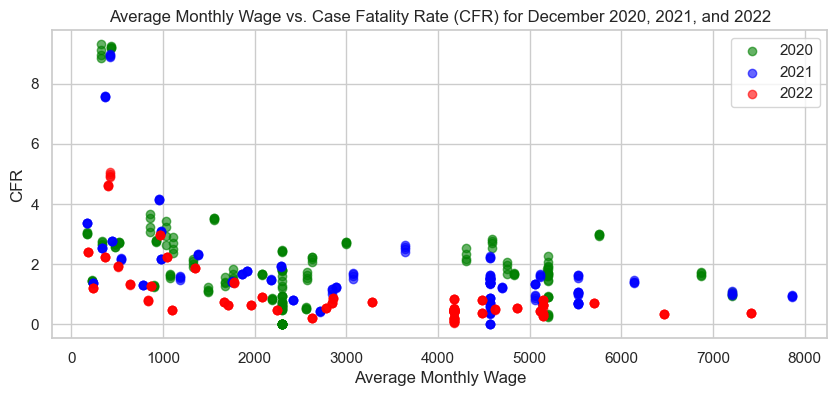

In [168]:
plt.figure(figsize=(10, 4))

plt.scatter(december_data[december_data['date'].dt.year == 2020]['Average Monthly wage'],
            december_data[december_data['date'].dt.year == 2020]['CFR'],
            alpha=0.6, label='2020', color='green')
plt.scatter(december_data[december_data['date'].dt.year == 2021]['Average Monthly wage'],
            december_data[december_data['date'].dt.year == 2021]['CFR'],
            alpha=0.6, label='2021', color='blue')
plt.scatter(december_data[december_data['date'].dt.year == 2022]['Average Monthly wage'],
            december_data[december_data['date'].dt.year == 2022]['CFR'],
            alpha=0.6, label='2022', color='red')

plt.title('Average Monthly Wage vs. Case Fatality Rate (CFR) for December 2020, 2021, and 2022')
plt.xlabel('Average Monthly Wage')
plt.ylabel('CFR')
plt.legend()

plt.show()

Most coutries, especially developed countries have very low fragile labor, while developing countries have higher informal employment rate and the portion is stable.

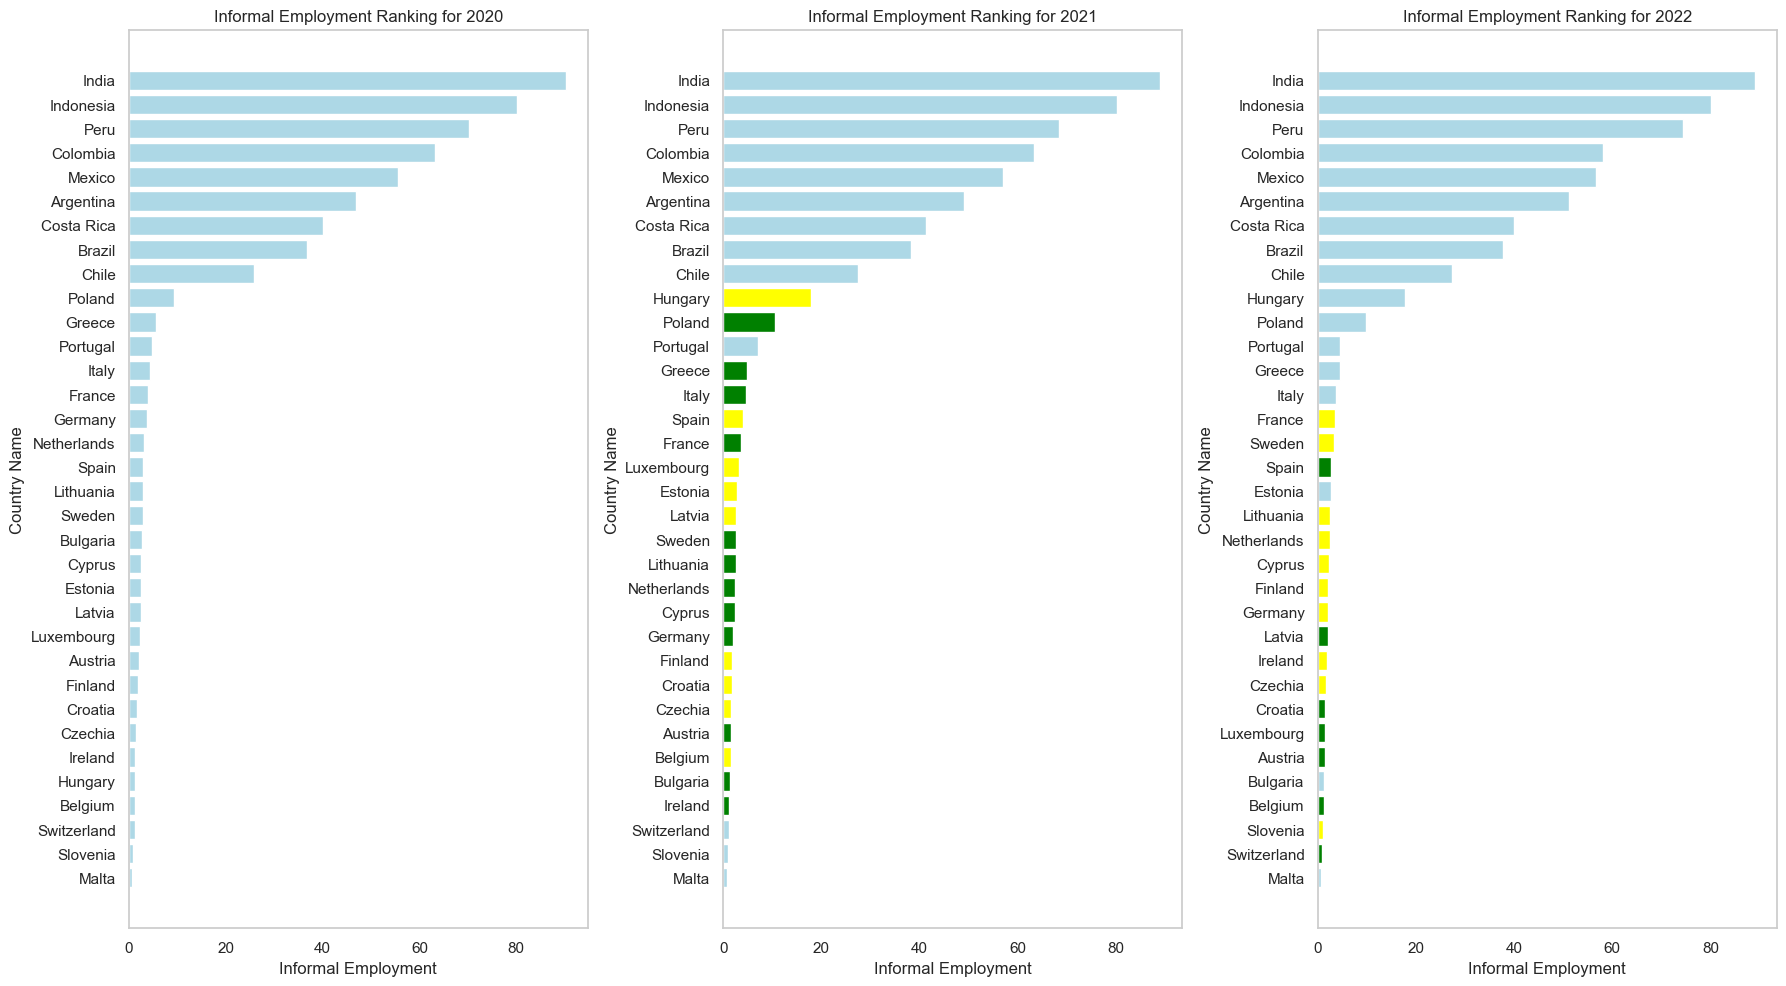

In [158]:
last_data_per_year['Rank'] = last_data_per_year.groupby('year')['Inefficient Employment'].rank(method='min', ascending=False)
informal_employment_wide = last_data_per_year.pivot(index='Country Name', columns='year', values='Rank')

informal_employment_wide['Rank Change 2'] = informal_employment_wide[2022] - informal_employment_wide[2021]
informal_employment_wide['Rank Change 1'] = informal_employment_wide[2021] - informal_employment_wide[2020]

plt.figure(figsize=(18, 10))
sns.set(style="whitegrid")

for i, year in enumerate(years):
    year_data = last_data_per_year[last_data_per_year['year'] == year]
    year_data = year_data.sort_values(by='Inefficient Employment', ascending=True)

    if year == 2022:
        year_data['Color'] = year_data['Country Name'].apply(
            lambda country: 'green' if informal_employment_wide.loc[country, 'Rank Change 2'] > 0 else 
            ('yellow' if informal_employment_wide.loc[country, 'Rank Change 2'] < 0 else 'lightblue')
        )
    elif year == 2021:
        year_data['Color'] = year_data['Country Name'].apply(
            lambda country: 'green' if informal_employment_wide.loc[country, 'Rank Change 1'] > 0 else 
            ('yellow' if informal_employment_wide.loc[country, 'Rank Change 1'] < 0 else 'lightblue')
        )
    else:
        year_data['Color'] = 'lightblue'  

    ax = plt.subplot(1, len(years), i + 1)
    for idx, row in year_data.iterrows():
        ax.barh(row['Country Name'], row['Inefficient Employment'], color=row['Color'])

    ax.set_title(f"Informal Employment Ranking for {year}")
    ax.set_xlabel("Informal Employment")
    ax.set_ylabel("Country Name")
    ax.grid(False) 

plt.tight_layout(pad=1)
plt.show()

The scatter plot is very similar to that of Gini index, where data scattered below 10 and has higer mean and variance for higher informal empoyment rates. This suggests that the relationship is more obvious for countries with more fragile employments.

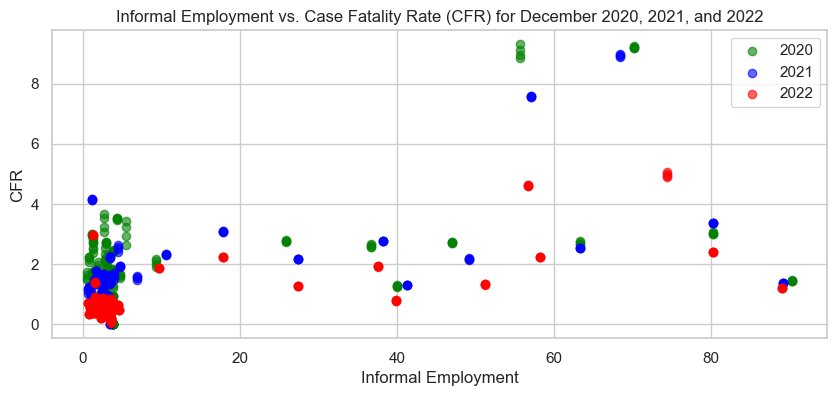

In [169]:
plt.figure(figsize=(10, 4))

plt.scatter(december_data[december_data['date'].dt.year == 2020]['Inefficient Employment'],
            december_data[december_data['date'].dt.year == 2020]['CFR'],
            alpha=0.6, label='2020', color='green')
plt.scatter(december_data[december_data['date'].dt.year == 2021]['Inefficient Employment'],
            december_data[december_data['date'].dt.year == 2021]['CFR'],
            alpha=0.6, label='2021', color='blue')
plt.scatter(december_data[december_data['date'].dt.year == 2022]['Inefficient Employment'],
            december_data[december_data['date'].dt.year == 2022]['CFR'],
            alpha=0.6, label='2022', color='red')

plt.title('Informal Employment vs. Case Fatality Rate (CFR) for December 2020, 2021, and 2022')
plt.xlabel('Informal Employment')
plt.ylabel('CFR')
plt.legend()

plt.show()

The chart below shows the top five countries in terms of income factors and stringent index (at the end of 2022). India, Colombia and many others appear several times. This suggests that there may be a correlation between these variables, which is reasonable since these all reflect a country's level of development. Nonetheless, I would not easily delete these variables because they all represent the income status of the country at different levels, which is the direction of our research.

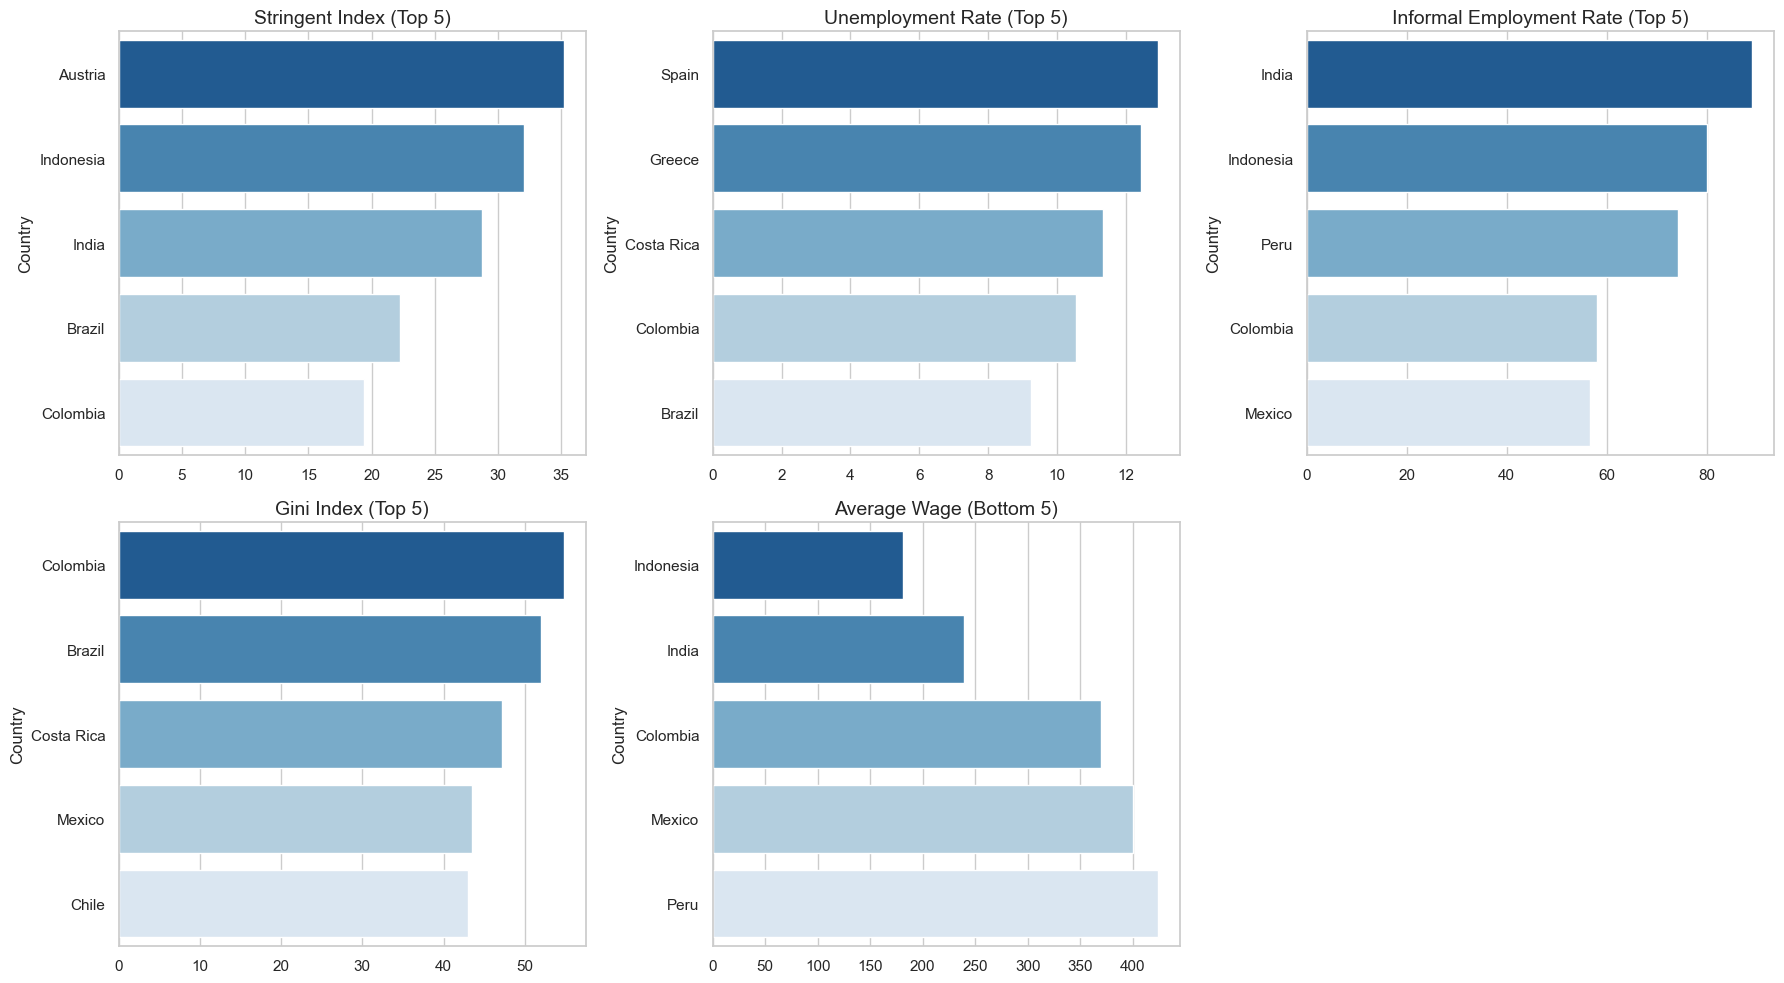

In [160]:
plt.figure(figsize=(18, 10))  

for i, (title, df) in enumerate(metrics.items(), 1):
    plt.subplot(2, 3, i)  
    sns.barplot(
        data=df,
        x=df.columns[1],  
        y="Country Name",
        palette="Blues_r",
        hue="Country Name",
        legend=False
    )
    plt.title(title, fontsize=14)
    plt.xlabel("")
    plt.ylabel("Country")

plt.tight_layout()  
plt.show()

<h3> Conclusion </h3>

Although the visualization alone only shows that average income seems strongly correlated with the CFR, while the Gini index and informal employment are only partially correlated, and the unemployment rate is not clearly correlated from the images, our observations are characterized by panel data, which implies that, in addition to the effects of multifactors acting in concert, there are also time effects and unobservable inter-country differences. The relationship between the factors and CFR will be investigated subsequently with robust statistical methods, such as **fixed effect model**, which will exclude the interference of time and country effects. (1487 words)

<h3> Citations </h3>

[1] Tan, A. X., Hinman, J. A., Abdel Magid, H. S., Nelson, L. M., & Odden, M. C. (2021). Association Between Income Inequality and County-Level COVID-19 Cases and Deaths in the US. JAMA Network Open, 4(5), e218799. https://doi.org/10.1001/jamanetworkopen.2021.8799

[2] Sepulveda, E. R., & Brooker, A. S. (2021). Income inequality and COVID-19 mortality: Age-stratified analysis of 22 OECD countries. SSM - population health, 16, 100904. https://doi.org/10.1016/j.ssmph.2021.100904

[3] Rahman, R., Kang, J., Rousseau, J. F., & Ding, Y. (2023). Analyzing Impact of Socio-Economic Factors on COVID-19 Mortality Prediction Using SHAP Value. ArXiv.org. https://arxiv.org/abs/2303.00517?utm_source=chatgpt.com

[4] Motallebi, S., Cheung, R. C. Y., Mohit, B., Shahabi, S., Tabriz, A. A., Sadeghi, B., & Moattari, S. (2021). Modeling COVID-19 Mortality Across 44 Countries: Face Covering May Reduce Deaths. American Journal of Preventive Medicine. https://doi.org/10.1016/j.amepre.2021.09.019

[5] Kim, S. Y., Yoo, D. M., Min, C., & Choi, H. G. (2021). The Effects of Income Level on Susceptibility to COVID-19 and COVID-19 Morbidity/Mortality: A Nationwide Cohort Study in South Korea. Journal of Clinical Medicine, 10(20), 4733. https://doi.org/10.3390/jcm10204733
